In [2]:
!pip install gensim==4.2.0 

  Using cached gensim-4.2.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached smart_open-6.1.0-py3-none-any.whl (58 kB)
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
import pickle
import string
import time
import re
import numpy as np
import statistics
import math
import warnings
warnings.filterwarnings('ignore')

In [94]:
data = pd.read_pickle('preprocess_data.pkl')
# data = pd.read_csv('preprocess_data.csv', encoding='utf-8', encoding_errors='ignore')
train = data.loc[data.flag=='train',:]
print(train.shape)
test = data.loc[data.flag=='test',:]
print(test.shape)

train.drop(columns=['flag'],inplace=True)
test.drop(columns=['flag'],inplace=True)


(55284, 30)
(29769, 30)


In [95]:
train.isnull().sum().sort_values(ascending=False)

neighborhood_overview          19506
host_response_time             17802
host_response_rate             17802
space                          16881
summary                         2954
host_has_profile_pic             111
host_identity_verified           111
host_since                       111
host_is_superhost                111
name                              14
guests_included                    0
review_scores_value                0
review_scores_location             0
review_scores_communication        0
reviews_per_month                  0
review_scores_checkin              0
review_scores_cleanliness          0
review_scores_accuracy             0
review_scores_rating               0
bedrooms                           0
price                              0
amenities                          0
bed_type                           0
beds                               0
bathrooms                          0
accommodates                       0
property_type                      0
h

In [96]:
##### Null treatment

def treat_null(df):
    for c in ['host_has_profile_pic','host_is_superhost','host_identity_verified','host_response_rate','host_response_time']:
        df[c].fillna(0,inplace=True)
    df['neighborhood_overview'].fillna('',inplace=True)
    df['space'].fillna('',inplace=True)
    df['summary'].fillna('',inplace=True)
    df['host_since'].fillna(statistics.median(df['host_since'].dropna().tolist()),inplace=True)
    return df


train = treat_null(train)
test = treat_null(test)

train.isnull().sum().sort_values(ascending=False)
    

name                           14
beds                            0
reviews_per_month               0
review_scores_value             0
review_scores_location          0
review_scores_communication     0
review_scores_checkin           0
review_scores_cleanliness       0
review_scores_accuracy          0
review_scores_rating            0
guests_included                 0
price                           0
amenities                       0
bed_type                        0
bedrooms                        0
summary                         0
bathrooms                       0
accommodates                    0
property_type                   0
host_identity_verified          0
host_has_profile_pic            0
host_total_listings_count       0
host_is_superhost               0
host_response_rate              0
host_response_time              0
host_since                      0
neighborhood_overview           0
space                           0
listing_id                      0
dtype: int64

In [97]:
###### Feature identification

target_col = 'price'
id_col = 'listing_id'
text_cols = ['name','summary','space','neighborhood_overview']
numeric_cols = [c for c in train.columns if c not in [target_col]+[id_col]+text_cols]


### Modeling with only numeric features

In [98]:
features = train.dropna()
X = features[[c for c in numeric_cols]]
y = features[target_col]

In [99]:
print(X.shape)
print(len(y))

(55270, 23)
55270


In [81]:
X_train, X_val,y_train,y_val = train_test_split(X,y, test_size=0.2, random_state=1)

#### Linear Regression

In [82]:
# feature selection

def select_linear_features(X_train, y_train, X_val, score_func):
	scale = StandardScaler().fit(X_train)
	X_train = scale.transform(X_train)
	X_val = scale.transform(X_train)
	fs = SelectKBest(score_func=score_func, k=15)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_val_fs = fs.transform(X_val)
	return X_train_fs, X_val_fs



cv = KFold(n_splits=10)
# feature selection
X_train_k, X_val_k = select_linear_features(X_train, y_train, X_val, mutual_info_regression)
model = LinearRegression()
cv_score = cross_val_score(model,X_train_k,y_train,scoring='neg_mean_absolute_percentage_error',cv=cv)
print("MSE: mean {:.2f} std {:.3f}".format(statistics.mean(cv_score)*-1, statistics.stdev(cv_score)))

# model.fit(X_train_fs, y_train)
# # evaluate the model
# yhat = model.predict(X_test_fs)
# # evaluate predictions
# mae = mean_absolute_error(y_test, yhat)
# print('MAE: %.3f' % mae)





MSE: mean 0.55 std 0.008


##### Stochastic Gradient Descent Regression

##### RandomForest Regression

##### GradientBoosting Regression

### Modeling with Text data included

In [6]:
#### load word2vec embeddings


from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases.load('bigram_model.pkl')

weights = KeyedVectors.load_word2vec_format('w2v_tmp.model')
vocab_size = len(weights)
vocab = [weights.index_to_key[i] for i in range(vocab_size)]
embedding_matrix = weights.vectors




FileNotFoundError: [Errno 2] No such file or directory: 'bigram_model.pkl'

In [92]:
type(features['summary'][0])

str

In [106]:
text_features = features[[c for c in text_cols]]
for c in text_features.columns:
    text_features[c] = text_features.apply(lambda x: ' '.join(x[c]), axis=1)

text_features.head(5)

,name,summary,space,neighborhood_overview
0,attic room historic greenwich,room door discreet staircase light airy open p...,double room available historic royal greenwich...,
1,lovely garden studio private access,garden studio private entrance minute crouch e...,beautiful studio king size bed sofa coffee tab...,crouch end hip friendly neighbourhood filled e...
2,comfi apartment close wimbledon tennis court,,,
3,luxury room heart london sw,luxury first floor victorian split level maiso...,room fully furnished include double bed mirror...,gail coffee shop round corner well local indep...
4,excellent city apartment private patio,new luxury apartment private outside patio gre...,modern well equipped cosy apartment close vict...,


In [75]:
sumamry = np.array(list(map(lambda x:len(x), features['summary'].tolist())))
print(np.percentile(sumamry,[25,50,75,90,99.7],))


space = np.array(list(map(lambda x:len(x), features['space'].tolist())))
print(np.percentile(space,[25,50,75,90,99.7],))


name = np.array(list(map(lambda x:len(x), features['name'].tolist())))
print(np.percentile(name,[25,50,75,90,99.7],))


neighborhood_overview = np.array(list(map(lambda x:len(x), features['neighborhood_overview'].tolist())))
print(np.percentile(neighborhood_overview,[25,50,75,90,99.7],))






[ 231.     350.     473.     522.    1026.193]
[   0.  205.  565.  953. 1157.]
[42. 51. 59. 65. 79.]
[   0.  163.  423.  826. 1097.]


In [116]:
text_features['summary'].str.encode('utf-8')

0        b'room door discreet staircase light airy open...
1        b'garden studio private entrance minute crouch...
2                                                      b''
3        b'luxury first floor victorian split level mai...
4        b'new luxury apartment private outside patio g...
                               ...                        
55279    b'large private double bedroom available brand...
55280                                                  b''
55281    b'double bedroom apartment family friend fully...
55282    b'amazing bed apartment offer ideal base trave...
55283    b'spacious bedroom beautiful ensuite perfect b...
Name: summary, Length: 55270, dtype: object

In [124]:
len(weights)

10271

In [123]:
features['summary']
vocab_temp = []
for c in features.summary.tolist():
    vocab_temp.extend(c)
# vocab_temp.extend([c for c in features['summary'].tolist()])
len(set(vocab_temp))

20288

In [134]:
t = text_features['summary'][0]

#### Regular text to vectors

In [132]:

Vectorizer = tf.keras.layers.TextVectorization()


#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(text_features['summary'])
# vocab = weights


#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = weights.get_vector(word)

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False)

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

##### Use of word2vec models

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-22 13:29:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-22 13:29:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-22 13:29:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
import os


path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))



Found 400000 word vectors.


In [ ]:
emb_dim = 100

def get_embedding_matrix(tokens, embeddings_index, vocab_len):

    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((vocab_len, emb_dim))
    for word, i in tokens.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))    
    
    return embedding_matrix
    

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    vocab_len,
    emb_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [7]:
# Load wiki2vec embeddings:

start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('Data/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/enwiki_20180420_100d.txt'

In [ ]:
emb_dim = 100

tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_text.fit_on_texts(X_train_nlp.text_clean)
NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1

X_tr_int_text = tokenizer_text.texts_to_sequences(X_train_nlp.text_clean)
max_article_length = max([len(article) for article in X_tr_int_text])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TEXT_LENGTH = 400
X_tr_int_pad_text = pad_sequences(X_tr_int_text, MAX_TEXT_LENGTH)

# Encode and pad the test data
X_ts_int_text = tokenizer_text.texts_to_sequences(X_test_nlp.text_clean)
X_ts_int_pad_text = pad_sequences(X_ts_int_text, MAX_TEXT_LENGTH)

wiki_weights_text, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)

##### LSTM

In [4]:
train = pd.read_csv('train.csv',encoding='utf-8')
test = pd.read_csv('test.csv',encoding='utf-8')

In [5]:
train_desc = train['description'].fillna('empty')
train_ngbr = train['neighborhood_overview'].fillna('empty')

y_train = train['price']


print(len(train_desc), len(train_ngbr), len(y_train))


def our_standardization(text_data):
    lowercase = tf.strings.lower(text_data) # convert to lowercase
    remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
    pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
    remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
    remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
    return remove_double_spaces



vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

emb_size = 100
rnn_units = 64


def create_text_model(text_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(layers.LSTM(rnn_units, return_sequences=False))
    model.add(layers.Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_desc = layers.Input(shape=(1,), dtype=tf.string)
    input_ngbr = layers.Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = layers.Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    return model


model = create_model()
print(model.summary())

history = model.fit(
    [train_desc, train_ngbr],
    y_train,
    validation_split=0.2,
    epochs = 20,
    batch_size = 32,
    verbose =1)

55284 55284 55284
(None, 2)
(None, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            1042305     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            1042305     input_2[0][0]                    
________________________________________________________

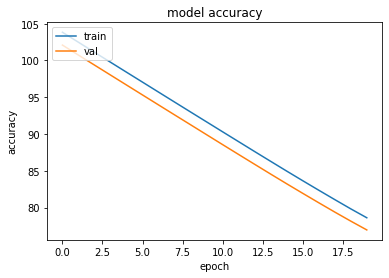

In [11]:
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

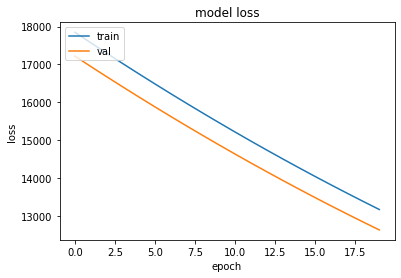

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### CNN-LSTM

In [18]:
train_desc = train['description'].fillna('')
train_ngbr = train['neighborhood_overview'].fillna('')

y_train = train['price']


print(len(train_desc), len(train_ngbr), len(y_train))


def our_standardization(text_data):
    lowercase = tf.strings.lower(text_data) # convert to lowercase
    remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
    pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
    remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
    remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
    return remove_double_spaces



vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

emb_size = 100
rnn_units = 64


def create_text_model(text_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    model.add(layers.LSTM(rnn_units, return_sequences=True))
    model.add(layers.Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = layers.Flatten()(X)
#     X = layers.Dense(128, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_desc = layers.Input(shape=(1,), dtype=tf.string)
    input_ngbr = layers.Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = layers.Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                  loss=losses.LogCosh(),
                  metrics=['mae'])
    return model


model = create_model()
print(model.summary())

history = model.fit(
    [train_desc, train_ngbr],
    y_train,
    validation_split=0.2,
    epochs = 5,
    batch_size = 64,
    verbose =1)

55284 55284 55284
(None, 248, 2)
(None, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 248, 1)       1028817     input_21[0][0]                   
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 248, 1)       1028817     input_22[0][0]                   
_________________________________________________

In [ ]:
tf.optimizers.Adam(learning_rate=1e-4)

##### Bidirectional LSTM

In [ ]:
train_desc = train['description'].fillna('empty')
train_ngbr = train['neighborhood_overview'].fillna('empty')

y_train = train['price']

In [ ]:
print(len(train_desc), len(train_ngbr), len(y_train))

In [ ]:
def our_standardization(text_data):
  lowercase = tf.strings.lower(text_data) # convert to lowercase
  remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
  pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
  remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
  remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
  return remove_double_spaces

In [ ]:
our_standardization(train_desc[0])

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

In [ ]:
desc1, desc2 = train_desc[2], train_desc[3]
print(desc1+'\n\n'+desc2)

ngbr1, ngbr2 = train_ngbr[2], train_ngbr[3]
print(ngbr1+'\n\n'+ngbr2)

In [ ]:
!nvidia-smi

tf.test.is_gpu_available()

In [ ]:
emb_size = 32
rnn_units = 16


def create_text_model(text_list):
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(LSTM(rnn_units, return_sequences=False))
    model.add(Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = Flatten()(X)
    X = Dense(1, activation="linear")(X)
    print(X.shape)
    return X

def create_model():
    
    ### Initialize Input layers
    input_desc = Input(shape=(1,), dtype=tf.string)
    input_ngbr = Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    return model








# desc_embedded = desc_model.predict([desc1,desc2])
# ngbr_model = create_text_model(train_ngbr)

# dense_desc = desc_model([desc2])
# dense_ngbr = ngbr_model([ngbr2])

# concatenated_values = layers.Concatenate([dense_model, ngbr_model])

# print(concatenated_values.shape)

# def create_model(text_features_list):
#   vec_model = 
#   for feature in text_features_list:
    


In [ ]:
# Create model with LSTM
emb_size = 100
rnn_units = 64

input_ngbr = tf.keras.Input(shape=(seq_length,), dtype="int64") 
input_desc = tf.keras.Input(shape=(seq_length,), dtype="int64") 
emb_desc = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_desc) 
x_desc = layers.GRU(rnn_units)(emb_desc)
dense_desc = layers.Dense(1, activation="relu")(x_desc)

emb_ngbr = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_ngbr) 
x_ngbr = layers.GRU(rnn_units)(emb_ngbr)
dense_ngbr = layers.Dense(1, activation="relu")(x_ngbr)

concat = concatenate([dense_desc, dense_ngbr])
norm = layers.BatchNormalization()(concat)
dense_full = Dense(128, activation="relu")(norm)
#dense_full = Dense(64, activation="relu")(dense_full)
output_layer = Dense(1, activation="relu")(dense_full)


model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output_layer) 

model.compile(optimizer='adam', 
    loss='mse', 
    metrics=['mae']) 
model.summary()

In [ ]:
# tf.convert_to_tensor([zip(train_desc,train_ngbr))
y_train = tf.convert_to_tensor(y_train)

In [ ]:
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_targets.values, tf.int64),

) 


def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1)  
    #return tf.squeeze(vectorize_layer(text))
    return tf.squeeze(vectorize_layer(text))

convert_text_input(["what is this misery","what is your story"]).shape

In [ ]:
# model = create_model()
# desc_model = create_text_model(train_desc)

# print(desc_model.summary())
# desc_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
story = model.fit(
   [train_desc, train_ngbr],
   y_train,
#     validation_split=0.2,
    epochs = 5,
    batch_size = 32,
    verbose =1)